In [8]:
import sys
sys.path.append("../../../algorithms/quantum_advantage/")

In [9]:
import pickle
from pathlib import Path
from tqdm import tqdm
import pandas as pd

rows = []
for fname in tqdm(Path("data/").glob("circuit_from_qiskit_h1-1e_*")):
    rows.append(pickle.load(open(fname, "rb")))

236it [01:25,  2.77it/s]


In [10]:
df = pd.DataFrame(rows, columns=rows[0].keys())

TODO use newer pytket

NameError: name 'plt' is not defined

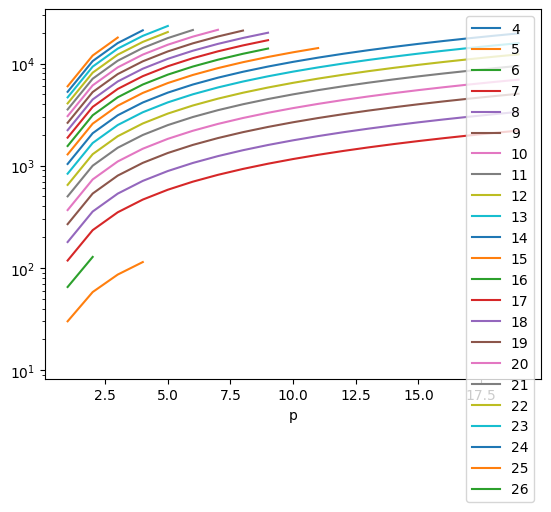

In [11]:
df[['N','p','ZZMax_depth']].sort_values('p').set_index('p').groupby('N')['ZZMax_depth'].plot(legend=True, logy=True)
plt.ylabel('ZZMax depth on H1-1E')

In [ ]:
import matplotlib.pyplot as plt

df[df['p'] == 1][['N','ZZMax_depth']].sort_values('N').set_index('N')['ZZMax_depth'].plot(legend=True)
plt.title("Depth of 1 QAOA layer")

In [18]:

from pytket import OpType
tmp = df[(df['N'] == 15) & (df['p'] < 5)]
# tmp.apply(
#     lambda row: len(row['compiled_circuit'].ops_of_type(OpType.ZZMax)),
#     axis=1
# )
tmp

,compiled_circuit,ZZMax_depth,N,p
51,"<tket::Circuit, qubits=15, gates=3250>",1290,15,1
80,"<tket::Circuit, qubits=15, gates=6485>",2578,15,2
201,"<tket::Circuit, qubits=15, gates=9711>",3866,15,3
226,"<tket::Circuit, qubits=15, gates=12939>",5154,15,4


## Pytket optimization improves depth

In [45]:
import numpy as np
from pathlib import Path

from pytket import OpType
from pytket.extensions.quantinuum import QuantinuumBackend
from pytket.extensions.qiskit import qiskit_to_tk

from labs import get_energy_term_indices
from qaoa_qiskit import get_qaoa_circuit

backend = QuantinuumBackend(device_name="H1-1E")


max_p_dict = {
    3: 1,
    4: 2,
    5: 5,
    6: 3,
    7: 20,
}

print("N\tp\tpytket\t qiskit")

for N in range(3, 35):
    terms, offset = get_energy_term_indices(N)
    if N in max_p_dict:
        max_p = max_p_dict[N]
    else:
        max_p = 20

    for p in range(1, max_p):
        outpath = f"data/circuit_from_qiskit_h1-1e_{N}_{p}.pickle"
        if not Path(outpath).exists():
            continue
        depth_pytket = pickle.load(open(outpath, "rb"))["ZZMax_depth"]
        
        beta = np.random.uniform(0, np.pi, p)
        gamma = np.random.uniform(0, np.pi, p)
        
        
        circ = qiskit_to_tk(get_qaoa_circuit(N, terms, beta, gamma, save_statevector=False))
        
        depth_qiskit = circ.depth_by_type(OpType.CX)
        print(f"{N}\t{p}\t{depth_pytket}\t{depth_qiskit}", flush=True)
        

N	p	pytket	 qiskit
4	1	12	16
5	1	30	39
5	2	58	76
5	3	86	113
5	4	114	150
6	1	65	81
6	2	128	160
7	1	118	138
7	2	234	274
7	3	350	410
7	4	466	546
7	5	582	682
7	6	698	818
7	7	814	954
7	8	930	1090
7	9	1046	1226
7	10	1162	1362
7	11	1278	1498
7	12	1394	1634
7	13	1510	1770
7	14	1626	1906
7	15	1742	2042
7	16	1858	2178
7	17	1974	2314
7	18	2090	2450
7	19	2206	2586
8	1	179	214
8	2	356	426
8	3	533	638
8	4	710	850
8	5	887	1062
8	6	1064	1274
8	7	1241	1486
8	8	1418	1698
8	9	1595	1910
8	10	1772	2122
8	11	1949	2334
8	12	2126	2546
8	13	2303	2758
8	14	2480	2970
8	15	2657	3182
8	16	2834	3394
8	17	3011	3606
8	18	3188	3818
8	19	3365	4030
9	1	268	306
9	2	534	610
9	3	800	914
9	4	1066	1218
9	5	1332	1522
9	6	1598	1826
9	7	1864	2130


KeyboardInterrupt: 

# Compare optimizing Qiskit circuit with optimizing from pytket starting point

In [27]:
import numpy as np
from pathlib import Path

from pytket import OpType
from pytket.extensions.quantinuum import QuantinuumBackend
from pytket.extensions.qiskit import qiskit_to_tk

from labs import get_energy_term_indices
from qaoa_qiskit import get_qaoa_circuit

backend = QuantinuumBackend(device_name="H1-1E")


max_p_dict = {
    3: 1,
    4: 2,
    5: 5,
    6: 3,
    7: 20,
}


df_small = pickle.load(open("data/circuit_depths_H1-1E_N_1-7.pickle", "rb"))

print("N\tp\tpytket\t qiskit")

for N in range(3, 35):
    terms, offset = get_energy_term_indices(N)
    if N in max_p_dict:
        max_p = max_p_dict[N]
    else:
        max_p = 20

    for p in range(1, max_p):
        if N <= 7:
            if len(df_small[(df_small['N'] == N) & (df_small['p'] == p)]) > 0:
                depth_pytket = df_small[(df_small['N'] == N) & (df_small['p'] == p)].squeeze()["ZZMax_depth"]
            else:
                depth_pytket = None
        else:
            outpath = f"data/circuit_h1-1e_{N}_{p}.pickle"
            if not Path(outpath).exists():
                continue
            depth_pytket = pickle.load(open(outpath, "rb"))["ZZMax_depth"]
        
        beta = np.random.uniform(0, np.pi, p)
        gamma = np.random.uniform(0, np.pi, p)
        
        
        circ = qiskit_to_tk(get_qaoa_circuit(N, terms, beta, gamma, save_statevector=False))

        compiled_circuit = backend.get_compiled_circuit(circ, optimisation_level=2)
        depth_qiskit = compiled_circuit.depth_by_type(OpType.ZZMax)
        print(f"{N}\t{p}\t{depth_pytket}\t{depth_qiskit}", flush=True)
        

N	p	pytket	 qiskit
4	1	14	12
5	1	41	30
5	2	80	58
5	3	119	86
5	4	158	114
6	1	85	65
6	2	168	128
7	1	144	118
7	2	286	234
7	3	428	350
7	4	570	466
7	5	712	582
7	6	854	698
7	7	996	814
7	8	1138	930
7	9	1280	1046
7	10	1422	1162
7	11	1564	1278
7	12	1706	1394
7	13	1848	1510
7	14	1990	1626
7	15	2132	1742
7	16	2274	1858
7	17	2416	1974
7	18	None	2090
7	19	None	2206
8	1	224	179
8	2	446	356
8	3	668	533
8	4	890	710
8	5	1112	887
8	6	1334	1064
8	7	1556	1241
8	8	1778	1418
8	9	2000	1595
8	10	2222	1772
8	11	2444	1949
8	12	2666	2126
8	13	2888	2303
8	14	3110	2480
8	15	3332	2657
8	16	3554	2834
8	17	3776	3011
8	18	3998	3188
8	19	4220	3365
9	1	320	268
9	2	638	534
9	3	956	800
9	4	1274	1066
9	5	1592	1332
9	6	1910	1598
9	7	2228	1864
9	8	2546	2130
9	9	2864	2396
9	10	3182	2662
9	11	3500	2928
9	12	3818	3194
9	13	4136	3460
9	14	4454	3726
9	15	4772	3992
9	16	5090	4258
9	17	5408	4524
9	18	5726	4790
9	19	6044	5056
10	1	446	368
10	2	890	734
10	3	1334	1100
10	4	1778	1466
10	5	2222	1832
10	6	2666	2198
10	7	3110	2564
10	8	35

KeyboardInterrupt: 

In [23]:
N = 5
p = 2

df_small = pickle.load(open("data/circuit_depths_H1-1E_N_1-7.pickle", "rb"))

In [25]:
df_small[(df_small['N'] == N) & (df_small['p'] == p)].squeeze()["ZZMax_depth"]

80

# Messing around with QSearch (not working yet, asked Ji for help)

In [5]:
import qiskit

from qsearch import utils

def unitary_from_circuit(qc):
    backend = qiskit.BasicAer.get_backend('unitary_simulator')
    job = qiskit.execute(qc, backend)
    U = job.result().get_unitary()
    BE = utils.endian_reverse(U)
    return BE


In [6]:
target_unitary = unitary_from_circuit(qc)

In [7]:
import qsearch
compiler = qsearch.SearchCompiler()
result = compiler.compile(target=target_unitary)

TypeError: compile() got an unexpected keyword argument 'target'

In [8]:
compiler.compile?

Signature:
compiler.compile(
    options=<qsearch.options.Options object at 0x7f861fb5df70>,
)
Docstring:
Args:
    options: See class level documentation for the options SearchCompiler uses
File:      /opt/omniai/work/instance1/jupyter/py38/lib/python3.8/site-packages/qsearch/compiler.py
Type:      method
